# Linear Regression Implementation on Diabetes dataset

- **Course:** CS675 – Introduction to Data Science (CRN: 73460)
- **Instructor:** Prof. Begimai Zhumakova
- **Group-1:** Syed Abdul Mubashir, Mohammed Abdul Munaf
- **Semester:** Fall 2024
- **Project #:** 2
- **Due Date:** 22-November-2024

## Load the Dataset and Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import xgboost as xgb

#Loading data using pandas
url = "https://web.stanford.edu/~hastie/Papers/LARS/diabetes.data"
df = pd.read_csv(url, delim_whitespace=True)

<ipython-input-16-5e70cc2dc3ec>:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True)


# Initial Data Inspection

In [ ]:
df.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGE     442 non-null    int64  
 1   SEX     442 non-null    int64  
 2   BMI     442 non-null    float64
 3   BP      442 non-null    float64
 4   S1      442 non-null    int64  
 5   S2      442 non-null    float64
 6   S3      442 non-null    float64
 7   S4      442 non-null    float64
 8   S5      442 non-null    float64
 9   S6      442 non-null    int64  
 10  Y       442 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


In [ ]:
print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} cols")

Dataset Shape: 442 rows, 11 cols


In [ ]:
df.isnull().sum().sort_values(ascending = False)

,0
AGE,0
SEX,0
BMI,0
BP,0
S1,0
S2,0
S3,0
S4,0
S5,0
S6,0


In [ ]:
df.describe()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


#Boxplot Before Outlier Handling

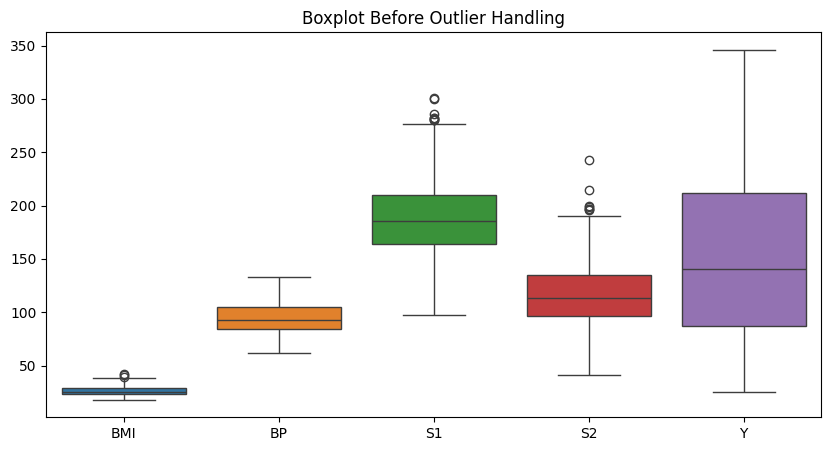

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot before handling outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['BMI', 'BP', 'S1', 'S2', 'Y']])  # Use the original dataframe
plt.title("Boxplot Before Outlier Handling")
plt.show()


#Outlier Detection and Handling

BMI: {'Lower Bound': 14.0875, 'Upper Bound': 38.387499999999996, 'Outliers Below': 0, 'Outliers Above': 3}
BP: {'Lower Bound': 52.5, 'Upper Bound': 136.5, 'Outliers Below': 0, 'Outliers Above': 0}
S1: {'Lower Bound': 96.0, 'Upper Bound': 278.0, 'Outliers Below': 0, 'Outliers Above': 8}
S2: {'Lower Bound': 38.37499999999999, 'Upper Bound': 192.175, 'Outliers Below': 0, 'Outliers Above': 7}
Y: {'Lower Bound': -99.75, 'Upper Bound': 398.25, 'Outliers Below': 0, 'Outliers Above': 0}


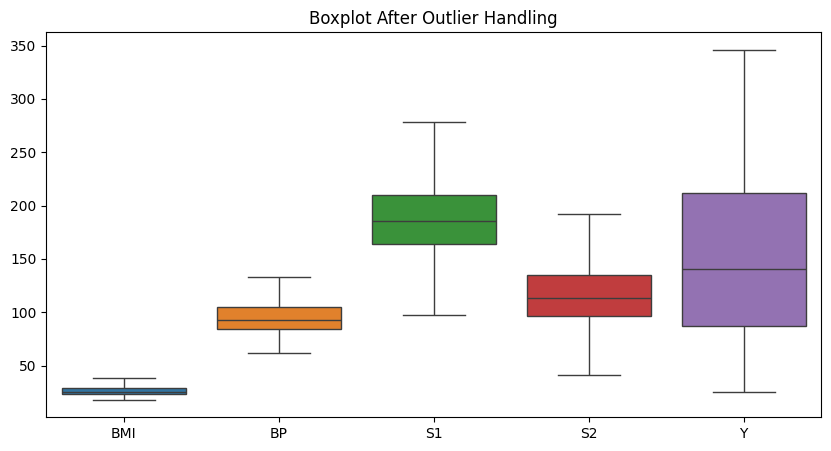

In [ ]:
# Define a function for detecting and handling outliers
def handle_outliers(df, columns):
    outlier_info = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers_below = (df[col] < lower_bound).sum()
        outliers_above = (df[col] > upper_bound).sum()
        outlier_info[col] = {'Lower Bound': lower_bound,
                             'Upper Bound': upper_bound,
                             'Outliers Below': outliers_below,
                             'Outliers Above': outliers_above}

        # Replace outliers with boundaries (capping)
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df, outlier_info

# List of columns to process
columns_to_check = ['BMI', 'BP', 'S1', 'S2', 'Y']

# Handle outliers
df_cleaned, outlier_summary = handle_outliers(df, columns_to_check)

# Display outlier summary
for feature, info in outlier_summary.items():
    print(f"{feature}: {info}")

# Visualize before and after for a sample feature
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_cleaned[columns_to_check])
plt.title("Boxplot After Outlier Handling")
plt.show()


#Task 1 Requirements
**Objective:** Predict y using a single feature of X (one at a time) and identify which feature best predicts y.

**Outputs:**
- **Model’s Coefficients:** Slope and intercept for each feature.
- **Linear Regression Graph:** Scatter plot of data points and regression line.
- **MSE (Mean Square Error):** Evaluate prediction performance.

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define target variable and features
X = df_cleaned.iloc[:, :-1]  # All columns except the last one ('Y')
y = df_cleaned['Y']          # Target column


In [ ]:
# Loop through all features in X and fit a linear regression model for each
for feature in X.columns:
    # Select the current feature as X_single
    X_single = df_cleaned[[feature]]

    # Fit the Linear Regression Model
    model = LinearRegression()
    model.fit(X_single, y)

    # Predict using the fitted model
    y_pred = model.predict(X_single)

    # Calculate MSE
    mse = mean_squared_error(y, y_pred)

    # Output the results
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f"Feature: {feature}, Slope: {slope:.2f}, Intercept: {intercept:.2f}, MSE: {mse:.2f}")


Feature: AGE, Slope: 1.10, Intercept: 98.52, MSE: 5720.55
Feature: SEX, Slope: 6.65, Intercept: 142.38, MSE: 5918.89
Feature: BMI, Slope: 10.36, Intercept: -121.07, MSE: 3886.87
Feature: BP, Slope: 2.46, Intercept: -80.77, MSE: 4774.11
Feature: S1, Slope: 0.48, Intercept: 61.13, MSE: 5659.70
Feature: S2, Slope: 0.46, Intercept: 98.61, MSE: 5739.78
Feature: S3, Slope: -2.35, Intercept: 269.29, MSE: 5005.66
Feature: S4, Slope: 25.72, Intercept: 47.46, MSE: 4831.14
Feature: S5, Slope: 83.51, Intercept: -235.48, MSE: 4031.00
Feature: S6, Slope: 2.56, Intercept: -81.94, MSE: 5062.38


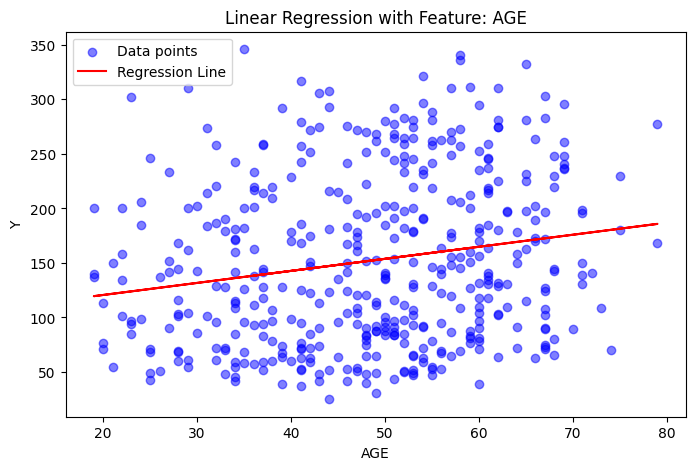

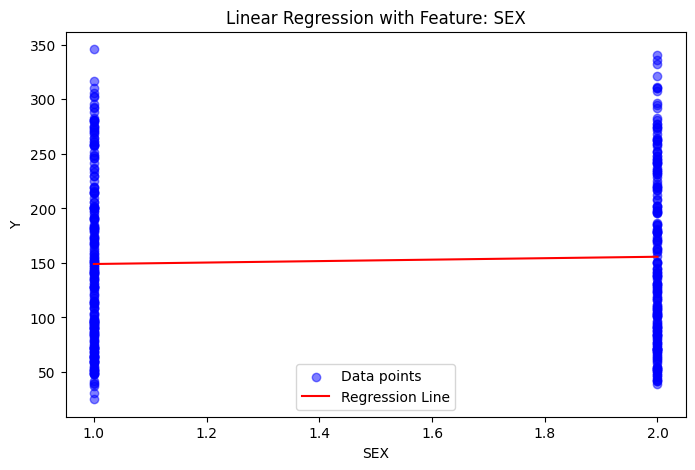

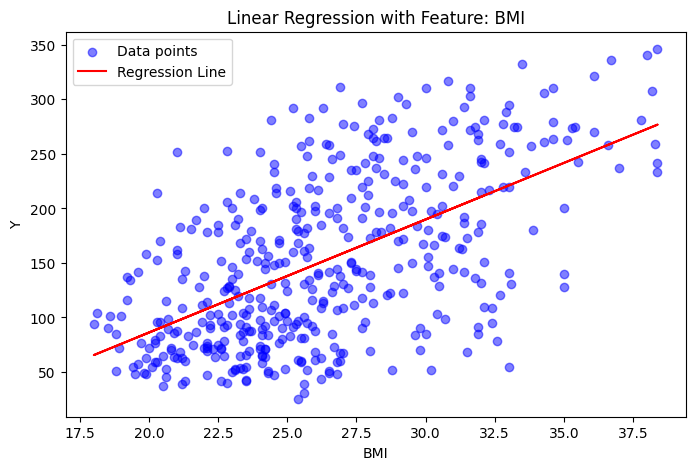

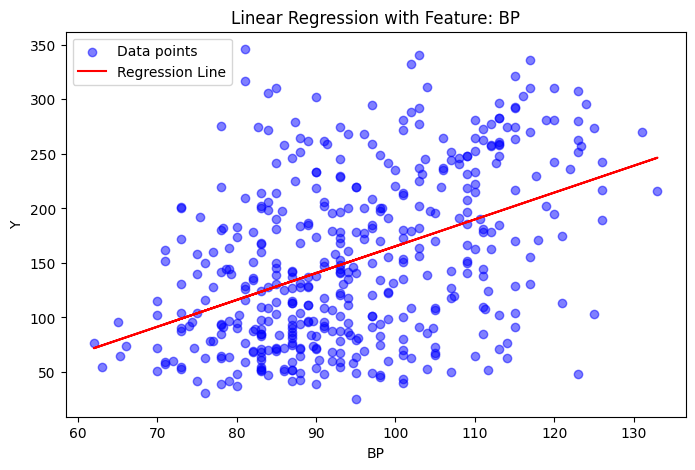

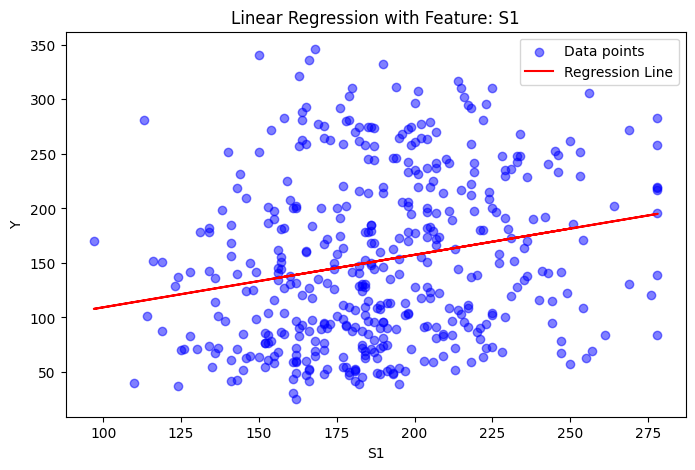

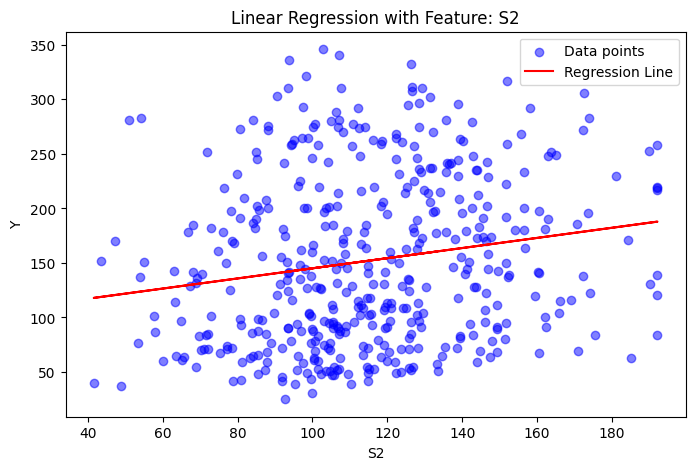

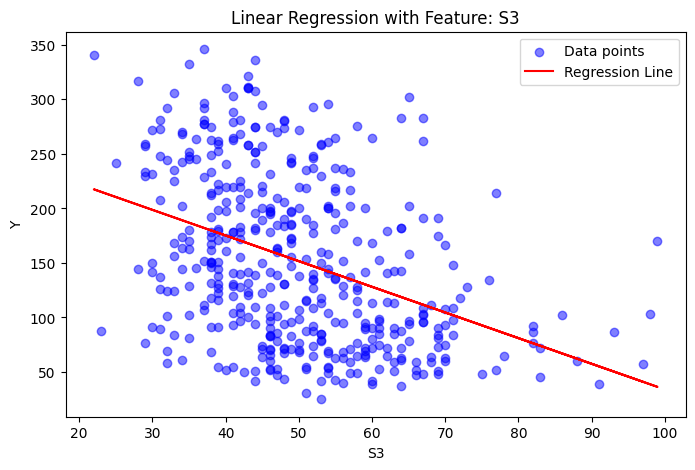

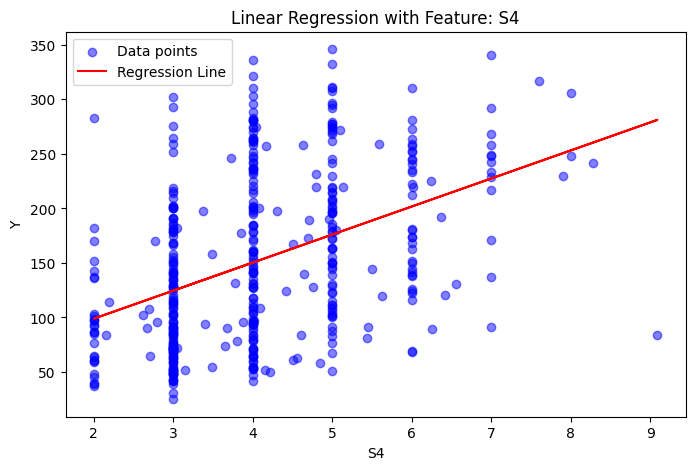

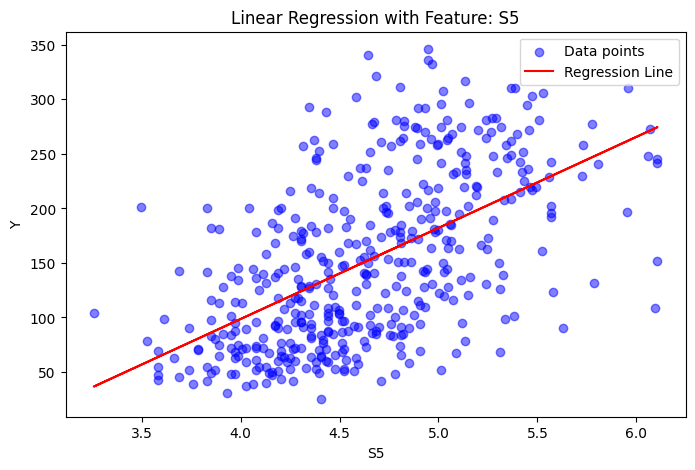

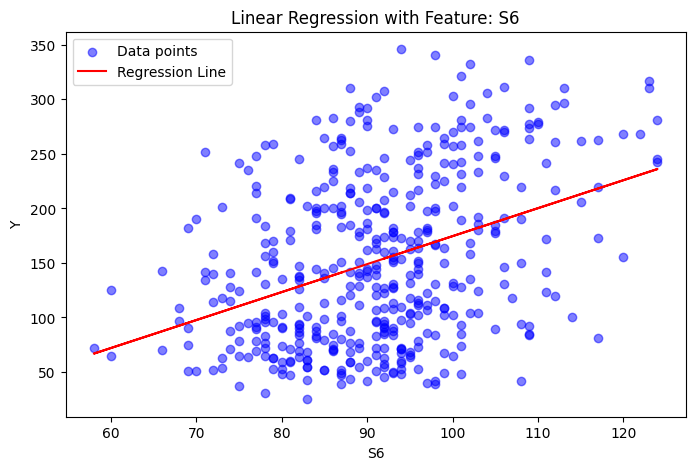

In [ ]:
for feature in X.columns:
    # Select the current feature as X_single
    X_single = df_cleaned[[feature]]

    # Fit the Linear Regression Model
    model = LinearRegression()
    model.fit(X_single, y)

    # Predict using the fitted model
    y_pred = model.predict(X_single)

    # Scatter plot and regression line
    plt.figure(figsize=(8, 5))
    plt.scatter(X_single, y, color='blue', alpha=0.5, label='Data points')
    plt.plot(X_single, y_pred, color='red', label='Regression Line')
    plt.title(f"Linear Regression with Feature: {feature}")
    plt.xlabel(feature)
    plt.ylabel('Y')
    plt.legend()
    plt.show()


In [ ]:
# Initialize variables to track the best feature
best_feature = None
lowest_mse = float("inf")

# Loop through all features in X
for feature in X.columns:
    X_single = df_cleaned[[feature]]
    model = LinearRegression()
    model.fit(X_single, y)
    y_pred = model.predict(X_single)
    mse = mean_squared_error(y, y_pred)

    # Update the best feature if this one has the lowest MSE
    if mse < lowest_mse:
        lowest_mse = mse
        best_feature = feature
        best_model = model

# Output the best feature and its details
slope = best_model.coef_[0]
intercept = best_model.intercept_
print(f"Best Feature: {best_feature}")
print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}, Lowest MSE: {lowest_mse:.2f}")


Best Feature: BMI
Slope: 10.36, Intercept: -121.07, Lowest MSE: 3886.87


#Task 2 Overview:
- You need to use pairs of features to predict y.
- For each pair of features:
 - Fit a linear regression model.
 - Plot the regression model (in a 3D plot, since we’re using two features).
 - Compute the MSE to evaluate which pair of features works best.

Step 1: Loop Through All Pairs of Features


In [ ]:
from itertools import combinations

# Initialize variables to track the best pair
best_pair = None
lowest_mse_pair = float("inf")

# Loop through all possible pairs of features
for pair in combinations(X.columns, 2):
    # Select the two features
    X_pair = df_cleaned[list(pair)]

    # Fit the Linear Regression Model
    model = LinearRegression()
    model.fit(X_pair, y)

    # Predict using the fitted model
    y_pred = model.predict(X_pair)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y, y_pred)

    # Check if this pair gives the lowest MSE
    if mse < lowest_mse_pair:
        lowest_mse_pair = mse
        best_pair = pair
        best_model = model

    print(f"Feature Pair: {pair}, MSE: {mse}")


Feature Pair: ('AGE', 'SEX'), MSE: 5719.883291630833
Feature Pair: ('AGE', 'BMI'), MSE: 3850.775211769089
Feature Pair: ('AGE', 'BP'), MSE: 4763.527994924995
Feature Pair: ('AGE', 'S1'), MSE: 5549.609171787995
Feature Pair: ('AGE', 'S2'), MSE: 5603.958043475929
Feature Pair: ('AGE', 'S3'), MSE: 4856.394064814031
Feature Pair: ('AGE', 'S4'), MSE: 4769.089423952994
Feature Pair: ('AGE', 'S5'), MSE: 4023.310408104431
Feature Pair: ('AGE', 'S6'), MSE: 5028.107124033965
Feature Pair: ('SEX', 'BMI'), MSE: 3886.4215855608204
Feature Pair: ('SEX', 'BP'), MSE: 4748.85656756619
Feature Pair: ('SEX', 'S1'), MSE: 5651.910454920453
Feature Pair: ('SEX', 'S2'), MSE: 5737.8305417793
Feature Pair: ('SEX', 'S3'), MSE: 4926.970243926759
Feature Pair: ('SEX', 'S4'), MSE: 4764.62399599863
Feature Pair: ('SEX', 'S5'), MSE: 4020.4132982509723
Feature Pair: ('SEX', 'S6'), MSE: 5054.102172035781
Feature Pair: ('BMI', 'BP'), MSE: 3586.888357203027
Feature Pair: ('BMI', 'S1'), MSE: 3859.0907148174497
Feature Pa

Step 2: Output Model’s Coefficients (Slope, y-Intercept)

In [ ]:
# Extract slope and intercept for the best pair
slope = best_model.coef_
intercept = best_model.intercept_
print(f"Best Feature Pair: {best_pair}")
print(f"Slope: {slope}, Intercept: {intercept}")


Best Feature Pair: ('BMI', 'S5')
Slope: [ 7.3638005  55.89995728], Intercept: -301.4233437087097


Step 3: Plotting the Regression Model

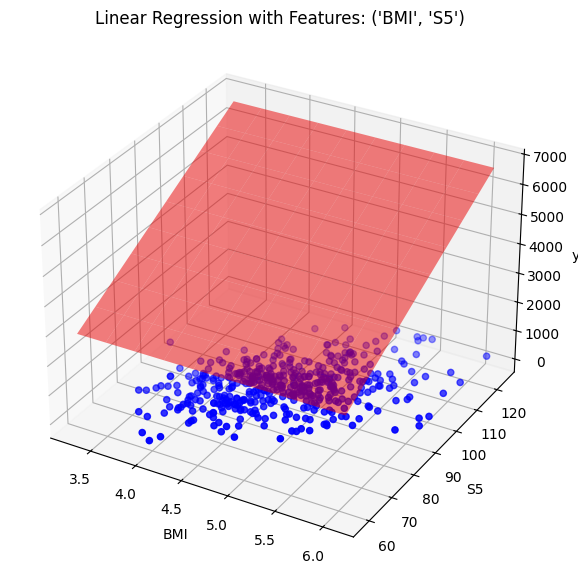

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Plotting the regression plane
X1_range = np.linspace(X_pair.iloc[:, 0].min(), X_pair.iloc[:, 0].max(), 10)
X2_range = np.linspace(X_pair.iloc[:, 1].min(), X_pair.iloc[:, 1].max(), 10)
X1_mesh, X2_mesh = np.meshgrid(X1_range, X2_range)

# Calculate the predicted y values for the plane
y_mesh = intercept + slope[0] * X1_mesh + slope[1] * X2_mesh

# 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], y, color='blue', label='Data points')
ax.plot_surface(X1_mesh, X2_mesh, y_mesh, color='red', alpha=0.5)

# Labels and title
ax.set_xlabel(best_pair[0])
ax.set_ylabel(best_pair[1])
ax.set_zlabel('y')
ax.set_title(f"Linear Regression with Features: {best_pair}")
plt.show()


Step 4: Compute the MSE for the Best Pair

In [ ]:
# Use the best pair for prediction
print(best_pair)
X_best_pair = df_cleaned[list(best_pair)]  # Get the best feature pair
y_pred = best_model.predict(X_best_pair)  # Predict using the best model

# Calculate MSE
mse = mean_squared_error(y, y_pred)
print(f"Best Pair MSE: {mse}")


('BMI', 'S5')
Best Pair MSE: 3207.3236475773188


#Task 3 Overview
In this task, we need to:

- Use all features in the dataset to predict y.
- Output:
 - Model’s coefficients: This will include the slope for each feature.
 - MSE (Mean Squared Error): This will measure the performance of the model.


Step 1: Select All Features and Fit the Model

In [ ]:
# Select all 10 features (excluding target 'y')
X_all = df_cleaned.iloc[:, :-1]  # All columns except 'Y'
y = df_cleaned['Y']  # Target variable

# Fit the Linear Regression Model using all features
model = LinearRegression()
model.fit(X_all, y)


LinearRegression()

Step 2: Output Model’s Coefficients (Slope, y-Intercept)

In [ ]:
# Output the coefficients and intercept for all features
slope = model.coef_
intercept = model.intercept_

# Print the coefficients (slopes) for each feature
for feature, coef in zip(X_all.columns, slope):
    print(f"Feature: {feature}, Slope: {coef}")
print(f"Intercept: {intercept}")


Feature: AGE, Slope: -0.04639131778012939
Feature: SEX, Slope: -23.023199238713794
Feature: BMI, Slope: 5.616085952486772
Feature: BP, Slope: 1.1124572675540039
Feature: S1, Slope: -1.3938552772613715
Feature: S2, Slope: 1.03454280214984
Feature: S3, Slope: 0.715515124383413
Feature: S4, Slope: 7.418249748190999
Feature: S5, Slope: 75.71428167447704
Feature: S6, Slope: 0.28105352604643574
Intercept: -363.7976562032153


Step 3: Calculate the Mean Squared Error (MSE)

In [ ]:
# Predict using the fitted model
y_pred = model.predict(X_all)

# Calculate MSE
mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error (MSE) using all features: {mse}")


Mean Squared Error (MSE) using all features: 2853.333461051446


#Task 4 Overview
- For each training set size (n_train), you will:
 - Split the dataset into training and validation sets.
 - Train a linear regression model on the training set.
 - Compute the MSE on the training set and the MSE on the validation set

1. Import Necessary Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


2. Define the Training Sizes and Perform MSE Calculations

In [ ]:
# Training sizes to test
training_sizes = [20, 50, 100, 200]

for n_train in training_sizes:
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_all, y, train_size=n_train, random_state=42)

    # Fit the model using the training set
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on the training set and calculate MSE
    y_train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)

    # Predict on the validation set and calculate MSE
    y_val_pred = model.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)

    # Output the results
    print(f"Training size: {n_train}, Training MSE: {train_mse:.2f}, Validation MSE: {val_mse:.2f}")


Training size: 20, Training MSE: 2066.51, Validation MSE: 16922.26
Training size: 50, Training MSE: 2852.80, Validation MSE: 3919.32
Training size: 100, Training MSE: 3148.95, Validation MSE: 3426.98
Training size: 200, Training MSE: 2863.99, Validation MSE: 2989.63


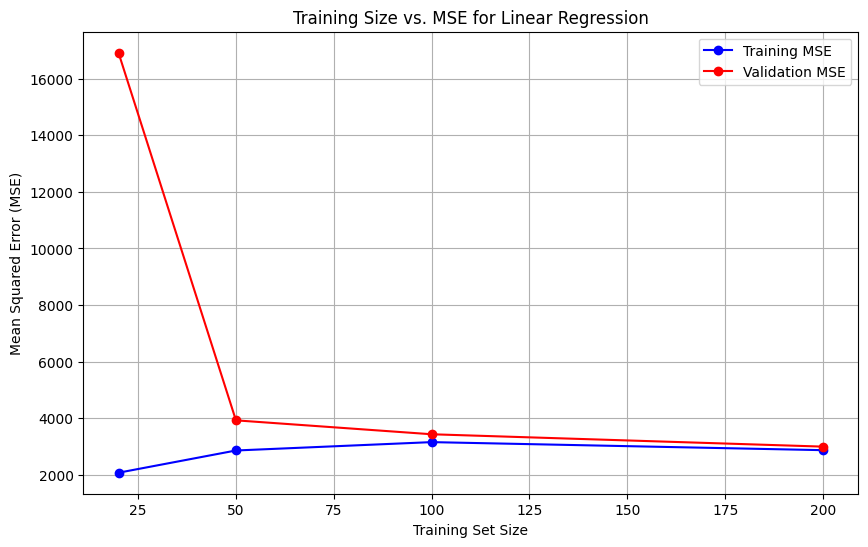

In [ ]:
import matplotlib.pyplot as plt

# Sample data from Task 4 (replace these lists with your actual MSE values)
training_sizes = [20, 50, 100, 200]
training_mse = [2066.51, 2852.80, 3148.95, 2863.99]
validation_mse = [16922.26, 3919.32, 3426.98, 2989.63]

# Plotting the Training MSE vs. Training Size
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, training_mse, marker='o', linestyle='-', color='b', label='Training MSE')
plt.plot(training_sizes, validation_mse, marker='o', linestyle='-', color='r', label='Validation MSE')

# Adding labels and title
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training Size vs. MSE for Linear Regression')
plt.legend()
plt.grid(True)
plt.show()


#Extra Credit
- Task 1 to 4 using XGBoost: Apply all tasks with XGBoost instead of Linear Regression.
- Compare the results: After completing all tasks with both models (Linear Regression and XGBoost), compare their MSE values.

Task 1: Predict the feature ‘y’ using a single feature of ‘X’

In [ ]:
import xgboost as xgb

best_mse_xgb = float("inf")
best_feature_xgb = None

for feature in X.columns:
    X_single = df_cleaned[[feature]]

    # Train XGBoost Model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model_xgb.fit(X_single, y)

    # Predict and calculate MSE
    y_pred_xgb = model_xgb.predict(X_single)
    mse_xgb = mean_squared_error(y, y_pred_xgb)

    if mse_xgb < best_mse_xgb:
        best_mse_xgb = mse_xgb
        best_feature_xgb = feature

    print(f"Feature: {feature}, XGBoost MSE: {mse_xgb}")

print(f"Best feature for predicting 'y' using XGBoost: {best_feature_xgb}")


Feature: AGE, XGBoost MSE: 5094.146932539559
Feature: SEX, XGBoost MSE: 5918.888899587645
Feature: BMI, XGBoost MSE: 2505.924068128927
Feature: BP, XGBoost MSE: 3733.1693221071296
Feature: S1, XGBoost MSE: 3949.381915902402
Feature: S2, XGBoost MSE: 2756.5490924707947
Feature: S3, XGBoost MSE: 4327.749961392089
Feature: S4, XGBoost MSE: 4080.4239440921183
Feature: S5, XGBoost MSE: 2414.79322191884
Feature: S6, XGBoost MSE: 4342.605811534234
Best feature for predicting 'y' using XGBoost: S5


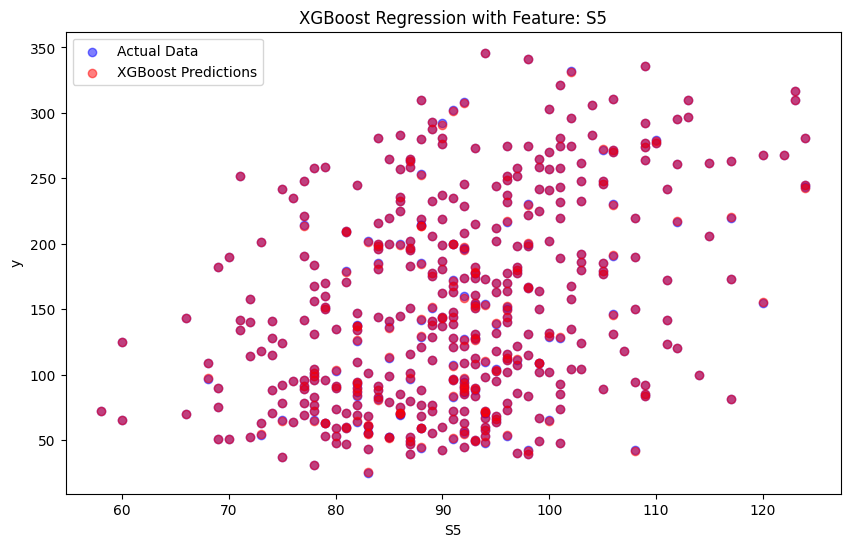

In [ ]:
# Plotting the Linear Regression results
plt.figure(figsize=(10, 6))
plt.scatter(X_single, y, color='blue', label='Actual Data', alpha=0.5)
plt.scatter(X_single, y_pred_xgb, color='red', label='XGBoost Predictions', alpha=0.5)
plt.xlabel(best_feature_xgb)
plt.ylabel('y')
plt.title(f"XGBoost Regression with Feature: {best_feature_xgb}")
plt.legend()
plt.show()

Task 2: Predict the feature ‘y’ using a pair feature of ‘X’

In [ ]:
from itertools import combinations

best_pair_xgb = None
lowest_mse_xgb = float("inf")

for pair in combinations(X.columns, 2):
    X_pair = df_cleaned[list(pair)]

    # Train XGBoost Model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model_xgb.fit(X_pair, y)

    # Predict and calculate MSE
    y_pred_xgb = model_xgb.predict(X_pair)
    mse_xgb = mean_squared_error(y, y_pred_xgb)

    if mse_xgb < lowest_mse_xgb:
        lowest_mse_xgb = mse_xgb
        best_pair_xgb = pair

    print(f"Feature Pair: {pair}, XGBoost MSE: {mse_xgb}")

print(f"Best feature pair for predicting 'y' using XGBoost: {best_pair_xgb}")


Feature Pair: ('AGE', 'SEX'), XGBoost MSE: 4323.761000364162
Feature Pair: ('AGE', 'BMI'), XGBoost MSE: 202.6257822225694
Feature Pair: ('AGE', 'BP'), XGBoost MSE: 544.1230485585274
Feature Pair: ('AGE', 'S1'), XGBoost MSE: 246.24056127812588
Feature Pair: ('AGE', 'S2'), XGBoost MSE: 226.6593044239179
Feature Pair: ('AGE', 'S3'), XGBoost MSE: 637.1618341541108
Feature Pair: ('AGE', 'S4'), XGBoost MSE: 2107.252489685803
Feature Pair: ('AGE', 'S5'), XGBoost MSE: 140.3409532951155
Feature Pair: ('AGE', 'S6'), XGBoost MSE: 672.7961500458122
Feature Pair: ('SEX', 'BMI'), XGBoost MSE: 1670.4527954429793
Feature Pair: ('SEX', 'BP'), XGBoost MSE: 3122.9273610276778
Feature Pair: ('SEX', 'S1'), XGBoost MSE: 2912.630651495982
Feature Pair: ('SEX', 'S2'), XGBoost MSE: 1679.0143983635905
Feature Pair: ('SEX', 'S3'), XGBoost MSE: 3790.637553421494
Feature Pair: ('SEX', 'S4'), XGBoost MSE: 3951.074283826318
Feature Pair: ('SEX', 'S5'), XGBoost MSE: 1799.6162406436433
Feature Pair: ('SEX', 'S6'), XGB

Task 3: Predict the feature ‘y’ using all (10) features of ‘X’
python
Copy code


In [ ]:
# Train XGBoost on all features
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model_xgb.fit(X_all, y)

# Predict and calculate MSE for XGBoost
y_pred_xgb = model_xgb.predict(X_all)
mse_xgb = mean_squared_error(y, y_pred_xgb)
print(f"XGBoost MSE using all features: {mse_xgb}")


XGBoost MSE using all features: 0.05351981765898635


Task 4: Compute the Training MSE and Validation MSE for Different Training Set Sizes

In [ ]:
from sklearn.model_selection import train_test_split

training_sizes = [20, 50, 100, 200]

for n_train in training_sizes:
    X_train, X_val, y_train, y_val = train_test_split(X_all, y, train_size=n_train, random_state=42)

    # Fit the XGBoost model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model_xgb.fit(X_train, y_train)

    # Predict and calculate MSE for training set
    y_train_pred = model_xgb.predict(X_train)
    train_mse_xgb = mean_squared_error(y_train, y_train_pred)

    # Predict and calculate MSE for validation set
    y_val_pred = model_xgb.predict(X_val)
    val_mse_xgb = mean_squared_error(y_val, y_val_pred)

    print(f"Training size: {n_train}, Training MSE: {train_mse_xgb}, Validation MSE: {val_mse_xgb}")


Training size: 20, Training MSE: 4.450470441952348e-07, Validation MSE: 5940.954266800859
Training size: 50, Training MSE: 3.985158400610089e-07, Validation MSE: 5399.099020960224
Training size: 100, Training MSE: 6.985328582231887e-07, Validation MSE: 4115.972488870861
Training size: 200, Training MSE: 0.00013241675531389774, Validation MSE: 3997.375766860902


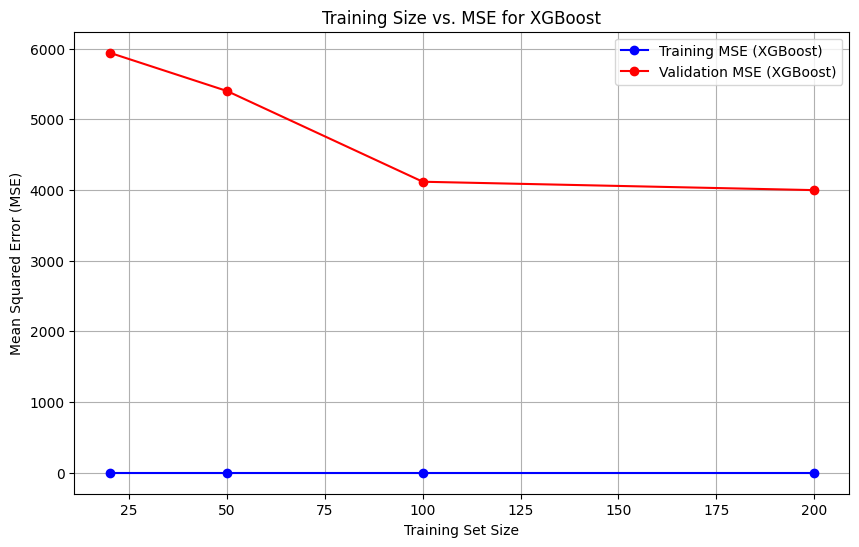

In [ ]:
# Data from XGBoost Task 4
training_sizes = [20, 50, 100, 200]
training_mse_xgb = [4.450470441952348e-07, 3.985158400610089e-07, 6.985328582231887e-07, 0.00013241675531389774]
validation_mse_xgb = [5940.954266800859, 5399.099020960224, 4115.972488870861, 3997.375766860902]

# Plotting the Training Size vs. MSE for XGBoost
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, training_mse_xgb, marker='o', linestyle='-', color='b', label='Training MSE (XGBoost)')
plt.plot(training_sizes, validation_mse_xgb, marker='o', linestyle='-', color='r', label='Validation MSE (XGBoost)')

# Adding labels and title
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training Size vs. MSE for XGBoost')
plt.legend()
plt.grid(True)
plt.show()
